# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':100000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# definition of Deep-TICA cvs 
deep: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG=p.x,p.y

# Bias 
opes: OPES_METAD ARG=deep.node-0,deep.node-1 TEMP=0.5 PACE=500 FILE=KERNELS BARRIER=7.5 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=deep.node-0,deep.node-1,p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data unbias/bias1/


## Trajectory 

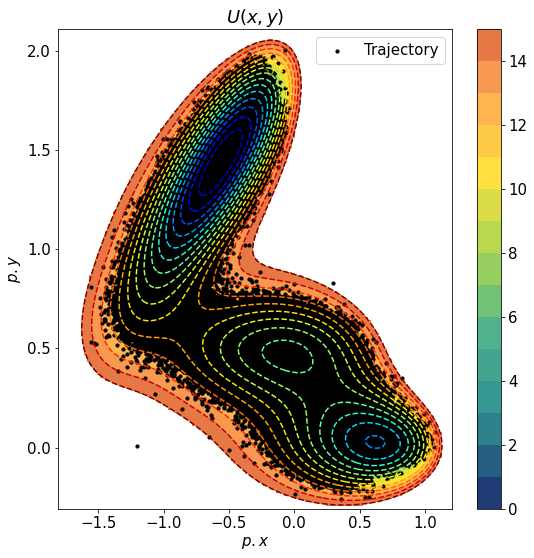

In [4]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values,load_dataframe(folder+"COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energy Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')
plt.tight_layout()

In [5]:
x = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()
N = len(x)
x = x.reshape(N)
weight= np.exp(np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"])

In [6]:
average = np.average(x,weights=weight)
variance = np.cov(x,aweights=weight)
print("average: ",average, ", variance: ",variance)

average:  -0.5629966656386415 , variance:  0.007658532615299648


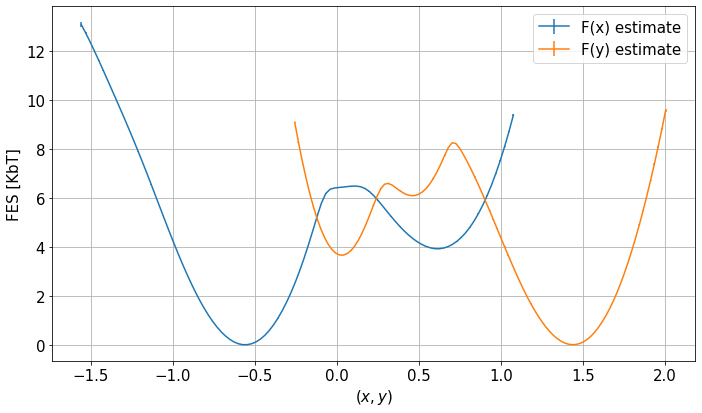

In [7]:
#-- estimation of Free Energy Surface 1D --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(10,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.tight_layout()
plt.show()

In [8]:
def gridspec_fes(s,logweight,sim_parameters):
    fig = plt.figure(figsize=(10,10))
    gs = GridSpec(4, 4)#, figure=fig)

    ax_scatter = fig.add_subplot(gs[1:4,0:3])
    ax_hist_x = fig.add_subplot(gs[0,:3])
    ax_hist_y = fig.add_subplot(gs[1:,3])

    #-- 2D plot --#
    fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
    bounds = np.arange(0, 16, 2.)
    cmap = plt.cm.get_cmap('fessa',len(bounds))
    colors = list(cmap(np.arange(len(bounds))))
    cmap = mpl.colors.ListedColormap(colors[:-1], "")
    # set over-color to last color of list 
    cmap.set_over("white")
    c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [KbT]"
    )
    c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [KbT]",
    )
    #fig.colorbar(c, ax=ax_scatter,label="FES [KbT]")
    c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [KbT]",
    )
    ax_scatter.legend(["FES [KbT]"])
    c.clabel()
    ax_scatter.grid()
    ax_scatter.set_xlabel(r"$x$")
    ax_scatter.set_ylabel(r"$y$")

    #-- 1D plot --#
    fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
    ax_hist_x.errorbar(grid,fes,yerr=error)
    ax_hist_x.set_ylabel("FES [KbT]")
    ax_hist_x.grid()
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_y)
    fes,grid,bounds,error = compute_fes(s[:,1], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_x)
    ax_hist_y.errorbar(fes,grid,xerr=error)
    ax_hist_y.set_xlabel("FES [KbT]")
    ax_hist_y.grid()

    plt.tight_layout()
    plt.show()

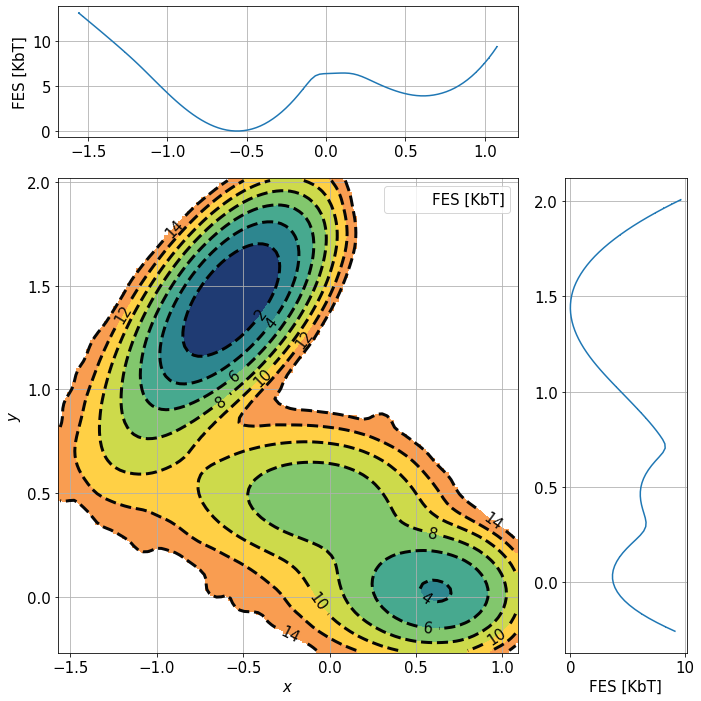

In [9]:
gridspec_fes(s,logweight,sim_parameters)

## Bias simulation DeepTICA Analysis and Export  
  
Before performing the next training we have to choose the `lag_time` again.  
Obviously one can think to look again at $C(\tau)$, but we must remember that now we are performing a biased simulation, an the time is *accelerated*.  
  
We can compute the time autocorrelation using the rescale time $d t \prime = d t e^{\beta V(\vec cv (\vec x))}$

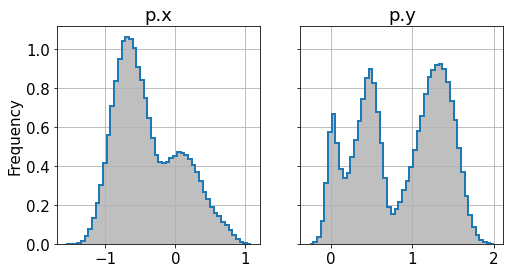

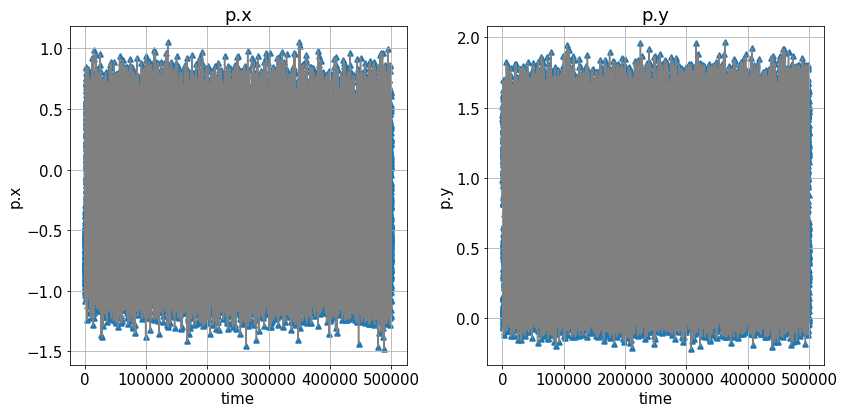

In [10]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

## Time Autocorrelation for Not evenly spaced sample  
```py
def find_time_lagged_configurations(x,t,lag):
    '''
    Searches for all the pairs which are distant 'lag' in time, and returns the weights associated to lag=lag as well as the weights for lag=0.

    Parameters:
        x (tensor): array whose columns are the descriptors and rows the time evolution
        time (tensor): array with the simulation time
        lag (float): lag-time

    Returns:
        x_t (tensor): array of descriptors at time t
        x_lag (tensor): array of descriptors at time t+lag
        w_t (tensor): weights at time t
        w_lag (tensor): weights at time t+lag
    '''
    #define lists
    x_t = []
    x_lag = []
    w_t = []
    w_lag = []
    #find maximum time idx
    idx_end = closest_idx_torch(t,t[-1]-lag)
    #start_j = 0
    
    #loop over time array and find pairs which are far away by lag
    for i in range(idx_end):
        stop_condition = lag+t[i+1]
        n_j = 0
        
        for j in range(i,len(t)):
            if ( t[j] < stop_condition ) and (t[j+1]>t[i]+lag):
                x_t.append(x[i])
                x_lag.append(x[j])
                deltaTau=min(t[i+1]+lag,t[j+1]) - max(t[i]+lag,t[j])
                w_lag.append(deltaTau)
                #if n_j == 0: #assign j as the starting point for the next loop
                #    start_j = j
                n_j +=1
            elif t[j] > stop_condition:
                break
        for k in range(n_j):
            w_t.append((t[i+1]-t[i])/float(n_j))

    x_t = torch.stack(x_t) if type(x) == torch.Tensor else torch.Tensor(x_t)
    x_lag = torch.stack(x_lag) if type(x) == torch.Tensor else torch.Tensor(x_lag)
    
    w_t = torch.Tensor(w_t)
    w_lag = torch.Tensor(w_lag)

    return x_t,x_lag,w_t,w_lag

def create_time_lagged_dataset(X, t = None, lag_time = 10, logweights = None):
    """
    Create a dataset of time-lagged configurations. If a set of (log)weights is given the search is performed in the accelerated time.

    Parameters
    ----------
    X : array-like
        input descriptors
    t : array-like, optional
        time series, by default np.arange(len(X))
    lag_time: float, optional
        lag between configurations, by default = 10        
    logweights : array-like,optional
        logweights to evaluate rescaled time as dt' = dt*exp(logweights)
    """

    # check if dataframe
    if type(X) == pandas.core.frame.DataFrame:
        X = X.values
    if type(t) == pandas.core.frame.DataFrame:
        t = t.values

    # assert
    assert t.ndim == 1 
    assert len(X) == len(t)

    # define time if not given
    if t is None:
        t = np.arange(0,len(X))

    # rescale time with log-weights if given
    if logweights is not None:
        # assert 
        assert logweights.ndim == 1
        assert len(X) == len(logweights)
        # compute time increment in simulation time t
        dt = np.round(t[1]-t[0],3)
        # sanitize logweights
        logweights = torch.Tensor(logweights)
        logweights -= torch.max(logweights)
        lognorm = torch.logsumexp(logweights,0)
        logweights /= lognorm
        # compute instantaneus time increment in rescaled time t'
        d_tprime = torch.exp(logweights)*dt
        # calculate cumulative time t'
        tprime = torch.cumsum(d_tprime,0)
    else:
        tprime = t

    # find pairs of configurations separated by lag_time
    data = find_time_lagged_configurations(X, tprime,lag=lag_time)

    #return data
    return torch.utils.data.TensorDataset(*data)
```

In [11]:
#-- compile cpp, longest procedure --#
execute("make",folder=folder)
#-- remove old files
#execute("rm w_lag.txt w_t.txt x_lag.txt x_t.txt",folder=folder, print_result=False)

#-- write input file to create time lagged dataset --#
path = "COLVAR"
names = load_dataframe(folder+path).filter(regex="^p.").columns
first_index = data.columns.get_loc(names[0])
last_index = data.columns.get_loc(names[-1])
weights_index = data.columns.get_loc("opes.bias")
skip = 0 
with open(folder+"input.dat","w") as file:
    print("""colvar = """+path+"""
skip_rows = """+str(skip)+"""
beta = """+str(1/sim_parameters["temp"])+"""
lag = 1
first_index = """+str(first_index)+"""
last_index = """+str(last_index)+"""
if_weights = 1
weights_index = """+str(weights_index)+"""
""",file=file)

Completed: make


In [12]:
def my_autocorrelation_cpp_all(inputFile,lag,path="./",weight=True):
    
    #-- modify lag time in input file --#
    execute("sed -i 's/lag.*/lag = "+str(lag)+"/g' "+inputFile,folder=path, print_result=False)

    #-- modify if_weight in input file --#
    if not weight:
        execute("sed -i 's/if_weights.*/if_weights = 0/g' "+inputFile,folder=path, print_result=False)
    else:
        execute("sed -i 's/if_weights.*/if_weights = 1/g' "+inputFile,folder=path, print_result=False)

    #-- ricordo che i weights vengono moltiplicati per beta dentro la funzione cpp --#
    data = create_time_lagged_dataset_cpp(inputFile,path=path)
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]),np.array(data[:][1]),np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.array([ np.average(x_t.T[i],weights=w_t) for i in range(x_t.shape[1]) ])
    variance = np.array([ np.cov(x_t.T[i],aweights=w_t) for i in range(x_t.shape[1]) ])
    autocorr = np.array([np.sum( np.multiply(np.multiply((x_t.T[i]-mean[i]),(x_lag.T[i]-mean[i])),w_lag))/(Nw*variance[i]) for i in range(x_t.shape[1])])
    
    return autocorr

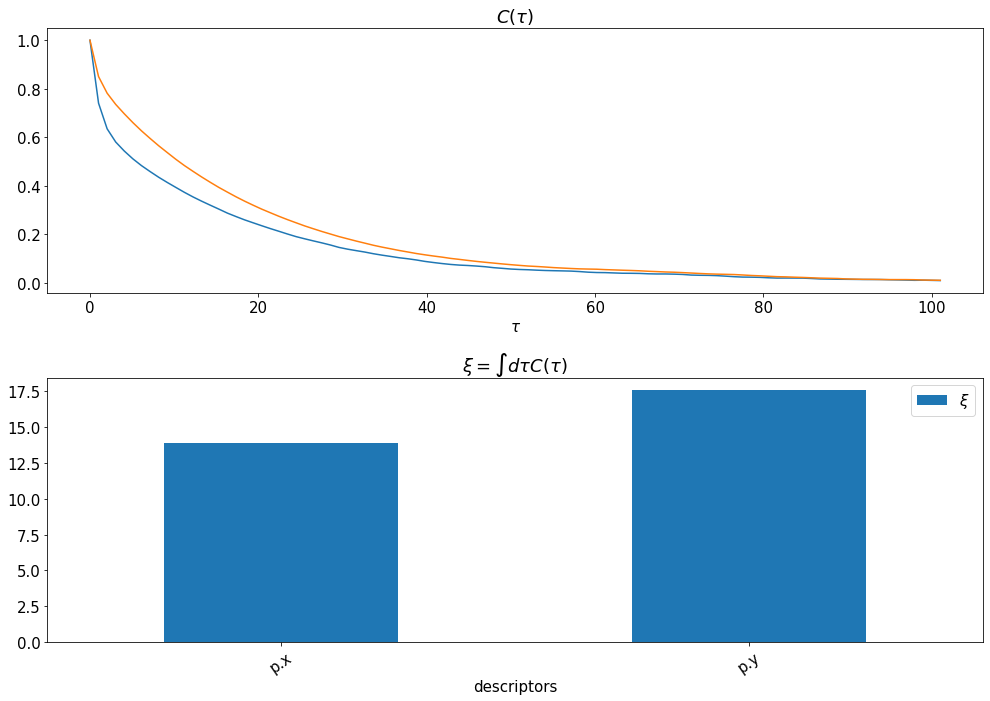

17.55980123482977
13.85559172265727


In [13]:
#-- fast way, one descriptor at once --#
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
last=100
x = np.linspace(0,last+1,last)
acorr = np.array([my_autocorrelation_cpp_all("input.dat",lag=i,path=folder,weight=True) for i in range(last)])
timescale = np.empty(len(descriptors_names))

for k in range(len(descriptors_names)):
    corr = acorr.T[k]
    axs[0].plot(x,corr)
    timescale[k] = integrate.trapz(corr[:last],x[:last])

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

In [14]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':2,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [15]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

Time-lagged pairs:	 988276
Training data:		 691793
Validation data:	 296483
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.962      -0.959      0.858  0.102  
100   -1.005      -1.000      0.861  0.139  
150   -1.035      -1.029      0.873  0.161  
200   -1.049      -1.042      0.883  0.166  
250   -1.058      -1.052      0.887  0.168  
300   -1.060      -1.054      0.888  0.168  
INFO: Early stopping
317   -1.064      -1.057      0.888  0.168  
already exists
model saved
timescales:  [16.876274   1.1226735]
eigenvalues:  [0.8882433  0.16839181]


## Load existing model  
  
I recall that it is always possible to load an existing model  

```py
data = load_dataframe(folder+"COLVAR")
search_values="^p."
X, t, logweight = data.filter(regex=search_values).values, data['time'].to_numpy(). data["opes.bias"].to_numpy()

logweight = ( logweight-max(logweight) ) / sim_parameters["temp"]

model = DeepTICA_CV(train_parameters["nodes"],activation=train_parameters['activ_type'])
model.load_checkpoint(folder+"deeptica/model_checkpoint.pt")
```

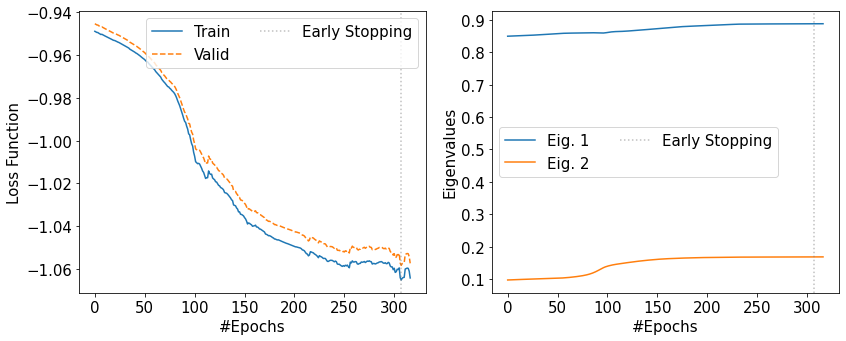

In [16]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [17]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

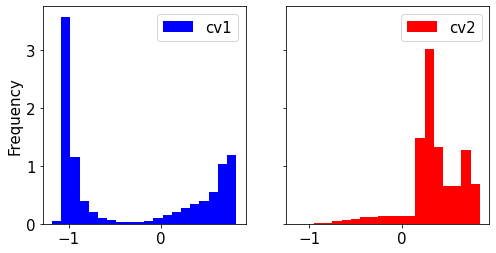

In [18]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

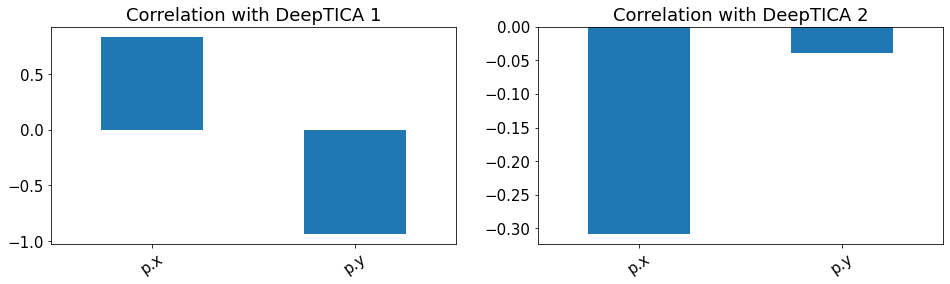

In [19]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from new cvs  

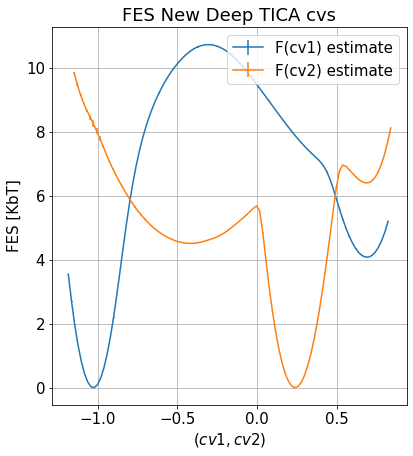

In [20]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New Deep TICA cvs")

plt.show()

### Free Energy Estimation from sampled Deep-TICA Cvs

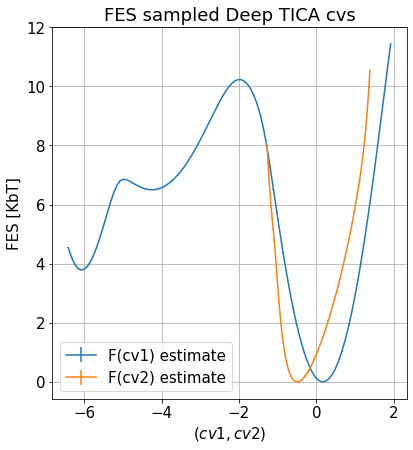

In [21]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^deep").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES sampled Deep TICA cvs")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

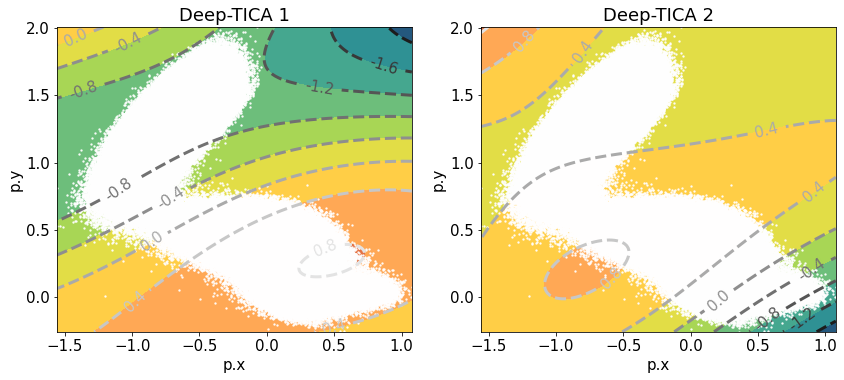

In [22]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

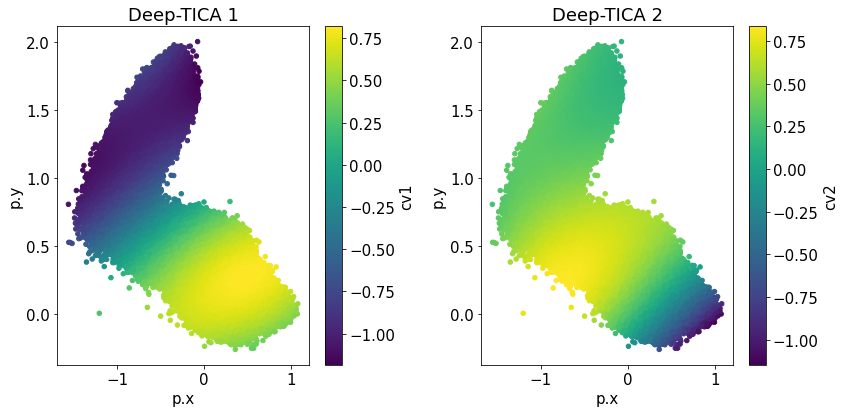

In [23]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
Now we want to estimate the scalar product of the Deep-TICA Cvs. In this case we have to reweight the integrale, because our points are distributed according to $p(\vec x) = \dfrac{e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))}}{\mathcal{Z}}$. Then finally the scalar product is computed from the following integral $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))} e^{\beta ( V(\vec cv(\vec x))}$.  
  
Even in this case, as already observed their scalar product on the data will lead to a result slightly different from $0$, due to the enforced simmetryzation of $C(\tau)$

In [24]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

-0.014700379786234454

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [25]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X,logweight=logweight)
prod = np.multiply(np.multiply(cv1,np.exp(logweight)),new_cv2).mean()
print(prod)

1.1895305194057727e-10


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

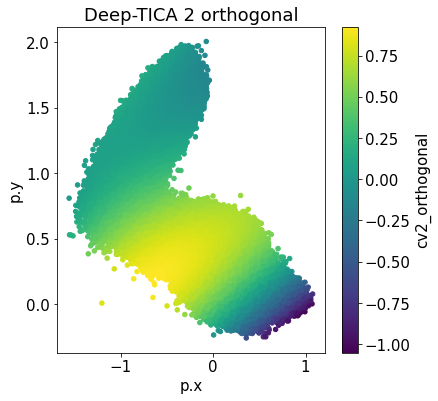

In [26]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="p.y",x="p.x",c="cv2_orthogonal",cmap="viridis",ax=ax)
ax.set_title('Deep-TICA 2 orthogonal')

## $\Delta F$ Estimate

Text(0.5, -0.03, 'shadow error of 0.5KbT')

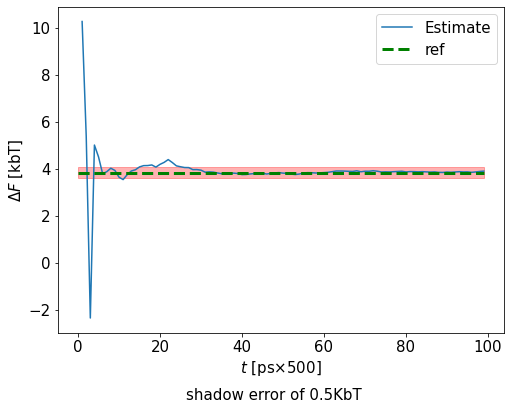

In [27]:
res = 3.841414368598573
#-- each step is 1ps --#
#-- we are interested in the first 50 ns --#
last = 1*1000*50#0 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))/sim_parameters["temp"]
#-- each step is 1ps --#
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=500

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        kbt=sim_parameters["temp"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) & (grid>-1.3)
    ind2 = (grid>0) & (grid<1)
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)
    
    deltaf = np.append(deltaf,(sim_parameters["temp"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.5*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.grid()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [kbT]")
txt = "shadow error of 0.5KbT"
# center text
fig.text(.5, -.03, txt, ha='center')